# Which one is a better plan?


<div style="border-left: 4px solid #007acc; padding: 0.5em 1em; background-color: #f0f8ff;">

This project analyzes user behavior across two prepaid plans — <strong>Surf</strong> and <strong>Ultimate</strong> — offered by the telecom operator <strong>Megaline</strong>. The main goal is to determine which plan generates more revenue and provides better business value.

The dataset includes 2018 records for 500 clients, detailing their monthly usage of calls, text messages, and internet traffic, as well as demographic information such as location and plan type.

To support strategic decisions, we explore usage patterns, calculate monthly revenues, and apply statistical tests to assess key differences between the two plans.

</div>

## Initialization

📚 Libraries needed for analysis

In [145]:

from IPython.display import Markdown, display

import pandas as pd
import numpy as np


from matplotlib import pyplot as plt
from math import factorial
from scipy import stats as st
import seaborn as sns

## Load data

🗂️ Data files

In [146]:

# Load the data files into different DataFrames


calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')




## Prepare the data

## Plans

🏄🏻‍♂️🏔️ **General/summary information about the `plans` DataFrame**



In [147]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


🏄🏻‍♂️🏔️ **Sample data**

In [148]:
plans.head(2)


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate



The `plans` DataFrame contains information about the two prepaid plans offered by Megaline:  🏄🏻‍♂️**Surf** and🏔️**Ultimate**. It includes 8 parameters:

- **plan_name** — calling plan name  
- **usd_monthly_fee** — monthly charge in US dollars  
- **minutes_included** — monthly minute allowance  
- **messages_included** — monthly text allowance  
- **mb_per_month_included** — data volume allowance (in megabytes)  
- **usd_per_minute** — price per minute after exceeding the package limits (e.g., if the package includes 100 minutes, the 101st minute will be charged)  
- **usd_per_message** — price per text after exceeding the package limits  
- **usd_per_gb** — price per extra gigabyte of data after exceeding the package limits (1 GB = 1024 megabytes)  

There is no missing data. However, two issues were identified:  
1. The **mb_per_month_included** column is expressed in megabytes, while it would be more practical to convert it to gigabytes, as Megaline rounds megabytes up to the nearest gigabyte.  
2. The **plan_name** column appears at the end of the DataFrame, but it may be more intuitive and readable to place it as the first column.

### Fix the data

➡️ **Converting the data volume allowance from megabytes to gigabytes**

To make the data easier to interpret and consistent with Megaline's billing practices—which round megabytes up to the nearest gigabyte—we convert the **mb_per_month_included** column from megabytes (MB) to gigabytes (GB).
**Note:** Although we are converting megabytes (MB) to gigabytes (GB), we are not rounding up the numbers per session, because individual web sessions are **not** rounded up.

In [149]:
plans['mb_per_month_included']=plans['mb_per_month_included']/1024
plans.rename(columns={'mb_per_month_included': 'gb_per_month_included'}, inplace=True)
plans ['gb_per_month_included']= plans ['gb_per_month_included'].astype(int)

➡️ **Setting the `plan name` column as the index**

To improve readability and facilitate data manipulation, we set the **plan_name** column as the index of the DataFrame. This makes it easier to reference each plan directly by name.


In [150]:
plans.set_index('plan_name')

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
plan_name,,,,,,,
surf,50,15,500,20,10,0.03,0.03
ultimate,1000,30,3000,70,7,0.01,0.01


## Users

 👥 General information about the `users` DataFrame


In [151]:
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


👥 Sample data

In [152]:
users.sample(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
480,1480,Jasper,Buchanan,46,"St. Louis, MO-IL MSA",2018-12-13,surf,NaN
423,1423,Malcom,Neal,61,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-10-16,surf,NaN
238,1238,Jackeline,Byrd,42,"Dallas-Fort Worth-Arlington, TX MSA",2018-06-16,surf,NaN
177,1177,Seymour,Anderson,33,"Seattle-Tacoma-Bellevue, WA MSA",2018-11-09,surf,NaN
224,1224,Kelly,Cole,74,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-06-28,ultimate,NaN


In [153]:
users['plan'].value_counts()

surf        339
ultimate    161
Name: plan, dtype: int64

👥 **Summary**

The `users` DataFrame contains demographic and subscription information for each user.
In total there are 500 users, 339 (67.8%) in the **Surf Plan** and 161 (32.2%) in the **Ultimate Plan**. 

It includes the following columns:

- **user_id** — unique user identifier  
- **first_name** — user's first name  
- **last_name** — user's last name  
- **age** — user's age (in years)  
- **reg_date** — date the user subscribed to the service (format: dd-mm-yy)  
- **churn_date** — date the user stopped using the service (if missing, the user was still active when the dataset was extracted)  
- **city** — user's city of residence  
- **plan** — name of the calling plan used by the user  

Identified issues:

1. The **reg_date** and **churn_date** columns are currently stored as an object. To enable accurate time-based operations—such it is necessary to convert them to pandas’ `datetime64[ns]` format.
2. The **churn_date** column contains many missing values (`NaN`). This is expected for users who were still active at the time the data was extracted.For now, we will not modify this column unless it becomes necessary in a later stage of our analysis.
3. The **user_id** column is currently stored as an integer. Since it represents a categorical identifier rather than a numerical value, it should be converted to a string type for clarity and consistency.

### Fix Data

➡️ **Converting date columns to datetime format**

To enable accurate time-based operations—such it is necessary to convert `reg_date` and `churn_date` columns  to pandas’ `datetime64[ns]` format. This ensures proper handling of date values and supports efficient time-based analysis.

In [154]:
users['reg_date']= pd.to_datetime(users['reg_date'])

In [155]:
users['churn_date']= pd.to_datetime(users['churn_date'])

➡️ **Converting the `user_ID` column to string type**

Since `user_id` is a unique identifier and not a numerical value to be computed or aggregated, we convert it from integer to string type. This change ensures clarity and prevents confusion during analysis, treating the identifier as a categorical variable rather than a quantitative one.

In [156]:
users['user_id'] = users['user_id'].astype('str')

➡️ **Checking fixed issues**

In [157]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    object        
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 31.4+ KB


## Calls

📞 **General/summary information about the `calls` DataFrame**


In [158]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


📞 **Sample data**

In [159]:
calls.head(5)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22



The `calls` DataFrame contains information about every call made by users. It includes the following columns:

- **id** — unique call identifier  
- **user_id** — identifier of the user who made the call
- **call_date** — date of the call  
- **duration** — call duration (in minutes)  

Identified issues:

1. There are no missing values (`NaN`) in this dataset.
2. The **user_id** column is currently stored as an integer.
3. The **call_date** column is currently stored as a string.
4. The values in the **duration** column should be rounded up to the nearest whole minute, to reflect Megaline's policy of rounding seconds up to full minutes.  
5. The column name **duration** does not specify that the values are in minutes.


### Fix data

➡️ **Converting the `user_ID` column to string type**

Since `user_id` functions as a categorical identifier, it should be converted to a string type for clarity and consistency.  

In [160]:
calls['user_id'] = calls['user_id'].astype('str')

➡️ **Converting the `call_date` column to datetime type**

To enable accurate time-based operations it is necessary to convert `call_date` column to pandas’ `datetime64[ns]` format. This ensures proper handling of date values and supports efficient time-based analysis.

In [161]:
calls['call_date']= pd.to_datetime(calls['call_date'])

➡️ **Rounding the `duration` column up**

The values in the `duration` column should be rounded up to the nearest whole minute, to reflect Megaline's policy of rounding seconds up to full minutes.

In [162]:
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype(int)

➡️ **Renaming the `duration` column**

For better readability and interpretability,it would be clearer to rename it to `duration_minutes`.

In [163]:
calls.rename(columns={'duration': 'duration_minutes'}, inplace=True)

➡️ **Checking fixed issues**

In [164]:
calls.head()

,id,user_id,call_date,duration_minutes
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5


### Enrich data

➡️ **Extracting year and month combining from the `call_date` column**

To aggregate call data by user and time period, we extract the **year and month** from the `call_date` column using pandas’ datetime functionality. This allows us to group the data so that each user has a single record per monthly period, facilitating time-based analysis and comparisons.

In [165]:
calls['month'] = calls['call_date'].dt.to_period('M')
calls.head()


,id,user_id,call_date,duration_minutes,month
0,1000_93,1000,2018-12-27,9,2018-12
1,1000_145,1000,2018-12-27,14,2018-12
2,1000_247,1000,2018-12-27,15,2018-12
3,1000_309,1000,2018-12-28,6,2018-12
4,1000_380,1000,2018-12-30,5,2018-12


## Messages

💬 **General/summary information about the `messages` DataFrame**

In [166]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


💬 **Sample data**

In [167]:
messages.sample(5)

,id,user_id,message_date
23456,1142_149,1142,2018-12-07
75165,1489_240,1489,2018-11-19
34971,1223_61,1223,2018-08-14
7829,1060_165,1060,2018-09-06
62788,1396_72,1396,2018-11-04


The `messages` DataFrame contains information about every text message sent by users. It includes the following columns:

- **id** — unique text message identifier  
- **message_date** — date the message was sent  
- **user_id** — identifier of the user who sent the message  

Identified issues:

1. There are no missing values (`NaN`) in this dataset.  
2. The **user_id** column is currently stored as an integer. Since it represents a categorical identifier, it should be converted to a string type for clarity and consistency.  
3. The **message_date** column is currently stored as a string. To enable proper time-based operations and analysis, it should be converted to datetime format.

### Fix data

➡️ **Converting the `user_ID` column to string type**

Since `user_id` functions as a categorical identifier, it should be converted to a string type for clarity and consistency.  

In [168]:
messages['user_id']= messages['user_id'].astype(str)

➡️ **Converting the `message_date` column to datetime type**

To enable accurate time-based operations it is necessary to convert message_date column to pandas’ `datetime64[ns]` format. This ensures proper handling of date values and supports efficient time-based analysis.

In [169]:
messages['message_date']= pd.to_datetime(messages['message_date'])

➡️ **Checking fixed issues**

In [170]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  object        
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


### Enrich data

➡️ **Extracting year and month combining from the `message_date` column**

To aggregate call data by user and time period, we extract the year and month from the `message_date` column using pandas’ datetime functionality. This allows us to group the data so that each user has a single record per monthly period, facilitating time-based analysis and comparisons.

In [171]:


messages['month'] = messages['message_date'].dt.to_period('M')
messages.head()




,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,2018-12
1,1000_160,1000,2018-12-31,2018-12
2,1000_223,1000,2018-12-31,2018-12
3,1000_251,1000,2018-12-27,2018-12
4,1000_255,1000,2018-12-26,2018-12


## Internet

🛜 **General/summary information about the `internet` DataFrame**

In [172]:
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


🛜 **Sample data**

In [173]:
internet.sample(5)


,id,user_id,session_date,mb_used
4462,1028_12,1028,2018-07-26,0.00
9659,1050_78,1050,2018-12-19,162.69
31336,1144_32,1144,2018-10-20,1020.30
33610,1153_73,1153,2018-12-28,0.00
8698,1045_430,1045,2018-12-09,82.80


The `internet` DataFrame contains information about users’ web session activity. It includes the following columns:

- **id** — unique session identifier  
- **mb_used** — volume of data used during the session (in megabytes)  
- **session_date** — date of the web session  
- **user_id** — identifier of the user who initiated the session  

#### Identified issues:

1. There are no missing values (`NaN`) in this dataset.  
2. The **user_id** column is currently stored as an integer. 
3. The **session_date** column is currently stored as a string.   
4. The **mb_used** column is expressed in megabytes. 


### Fix data

➡️ **Converting the `user_ID` column to string type**

Since `user_id` functions as a categorical identifier, it should be converted to a string type for clarity and consistency.  

In [174]:
internet['user_id']=internet['user_id'].astype(str)

➡️ **Converting the `session_date` column to datetime type**

To enable accurate time-based operations it is necessary to convert `message_date` column to pandas’ `datetime64[ns]` format. This ensures proper handling of date values and supports efficient time-based analysis.

In [175]:
internet['session_date']= pd.to_datetime(internet['session_date'])

➡️ **Converting the volume of data used during the session from megabytes to gigabytes**

To make the data easier to interpret and consistent with Megaline's billing practices—which round megabytes up to the nearest gigabyte—we convert the `mb_used` column from megabytes (MB) to gigabytes (GB).

In [176]:
internet['mb_used']=internet['mb_used']/1024


In [177]:
internet = internet.rename(columns={'mb_used': 'gb_used'})

➡️ **Checking fixed issues**

In [178]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  object        
 2   session_date  104825 non-null  datetime64[ns]
 3   gb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.2+ MB


### Enrich data

➡️ **Extracting Year and month combining from the `session_date` column**

To aggregate call data by user and time period, we extract the year and month from the `session_date` column using pandas’ datetime functionality. This allows us to group the data so that each user has a single record per monthly period, facilitating time-based analysis and comparisons.

In [179]:

internet['month'] = internet['session_date'].dt.to_period('M')
internet.head()



,id,user_id,session_date,gb_used,month
0,1000_13,1000,2018-12-29,0.087754,2018-12
1,1000_204,1000,2018-12-31,0.000000,2018-12
2,1000_379,1000,2018-12-28,0.644922,2018-12
3,1000_413,1000,2018-12-26,0.264639,2018-12
4,1000_442,1000,2018-12-27,0.859590,2018-12


## Study plan conditions

In [180]:
plans


,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Aggregate data per user

 We need to aggregate data per user per period in order to have just one record per user per period.
 
 ➡️ First, we create new columns to calculate the number of calls, the amount of minutes spent calling, the number of messages and the volume of internet traffic used by each user per month. 

📞 **calls by user per month**

In [181]:
calls_by_user_month = calls.groupby(['user_id','month']).size().reset_index(name='n_calls')

📞 ⏱️ **minutes spent by each user per month**

In [182]:
minutes_by_user_month = calls.groupby(['user_id','month'])['duration_minutes'].sum().reset_index()


💬 **number of messages sent by each user per month**

In [183]:
messages_by_user_month = messages.groupby(['user_id','month']).size().reset_index(name='n_messages')

🛜 **volume of internet traffic used by each user per month**

To reflect Megaline's policy of rounding seconds up to full minutes on the total web traffic for each customer per month, we round the total number of gigabytes.



In [184]:

MB_by_user_month = internet.groupby(['user_id','month'])['gb_used'].sum().reset_index()
MB_by_user_month['gb_used'] = np.ceil(MB_by_user_month['gb_used'])
MB_by_user_month['gb_used'] = MB_by_user_month['gb_used'].astype(int)


➡️ Second, we aggregate data together into one DataFrame so that one record in it would represent what an unique user consumed in a given month.

In [185]:

# Merge the data for calls, minutes, messages, internet based on user_id and month


data_by_user_month = calls_by_user_month.merge(minutes_by_user_month, on=['user_id','month'], how='outer')\
                                        .merge(messages_by_user_month, on=['user_id','month'],how='outer')\
                                      .merge(MB_by_user_month, on=['user_id','month'], how='outer')


In [186]:
data_by_user_month=data_by_user_month.fillna(0)

➡️ Third, we add the plan information

In [187]:
data_by_user_month = data_by_user_month.merge(users[['plan','user_id']], on='user_id')

➡️ Lastly, we calculate the monthly revenue from each user.

1. We create columns for the limits of every plan from the total number of calls, text messages, and internet data. 

In [188]:
data_by_user_month['monthly_charge'] = np.where(data_by_user_month['plan'] == 'surf', 20,70)

data_by_user_month['calls_limit'] = np.where(data_by_user_month['plan'] == 'surf', 500,3000)
data_by_user_month['messg_limit'] = np.where(data_by_user_month['plan'] == 'surf', 50,1000)
data_by_user_month['intrnt_limit'] = np.where(data_by_user_month['plan'] == 'surf', 15,30)


data_by_user_month['calls_rate'] = np.where(data_by_user_month['plan'] == 'surf', 0.03,0.01)
data_by_user_month['messg_rate'] = np.where(data_by_user_month['plan'] == 'surf', 0.03,0.01)
data_by_user_month['intrnt_rate'] = np.where(data_by_user_month['plan'] == 'surf', 10,7)


2. We apply the charges depending on the calling plan and the customer behavior.



In [189]:
data_by_user_month['charges_calls'] = np.where(data_by_user_month['duration_minutes'] > data_by_user_month['calls_limit'], 
                                               (data_by_user_month['duration_minutes'] - data_by_user_month['calls_limit']) * data_by_user_month['calls_rate'], 
                                               0)
data_by_user_month['charges_messg'] = np.where(data_by_user_month['n_messages'] > data_by_user_month['messg_limit'], 
                                               (data_by_user_month['n_messages'] - data_by_user_month['messg_limit']) * data_by_user_month['messg_rate'], 
                                               0)
data_by_user_month['charges_intrnt'] = np.where(data_by_user_month['gb_used'] > data_by_user_month['intrnt_limit'], 
                                               (data_by_user_month['gb_used'] - data_by_user_month['intrnt_limit']) * data_by_user_month['intrnt_rate'], 
                                               0)

3. We calculate the monthly revenue from each user.

In [190]:


data_by_user_month['monthly_revenue']= data_by_user_month['monthly_charge']+ data_by_user_month['charges_calls'] + data_by_user_month['charges_messg'] + data_by_user_month['charges_intrnt']
data_by_user_month.sample()



,user_id,month,n_calls,duration_minutes,n_messages,gb_used,plan,monthly_charge,calls_limit,messg_limit,intrnt_limit,calls_rate,messg_rate,intrnt_rate,charges_calls,charges_messg,charges_intrnt,monthly_revenue
239,1055,2018-11,28.0,231.0,95.0,15.0,surf,20,500,50,15,0.03,0.03,10,0.0,1.35,0.0,21.35


## Study user behaviour

### Calls 📞

➡️ 📞  **1**. We **calculate descriptive statistics** for the aggregated and merged data and  compare descriptive statistics of monthly call duration between the two available plans: surf and ultimate

In [191]:
calls_per_plan_month = data_by_user_month.groupby(['plan'])['duration_minutes']
calls_per_plan_month.describe()

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,428.749523,234.453150,0.0,272.0,425.0,576.00,1510.0
ultimate,720.0,430.450000,240.508762,0.0,260.0,424.0,565.25,1369.0


In [192]:

calls_per_plan_total_var = data_by_user_month.groupby(['plan'])['duration_minutes'].var().reset_index()
calls_per_plan_total_var.rename(columns={'duration_minutes': 'duration_var'}, inplace=True)
calls_per_plan_total_var


,plan,duration_var
0,surf,54968.279461
1,ultimate,57844.464812


### 🔍 **Insights**: Summary Statistics by Plan

- The Surf and Ultimate plans have similar average call durations (~430 minutes), despite their different call allowances (500 min vs. 3000 min). 
- The distribution of usage (percentiles and standard deviation) is also quite similar, indicating that most users behave similarly regardless of the plan. However, Ultimate shows **higher variability**, both in standard deviation and variance.  
- This suggests that Ultimate users have more diverse usage patterns, while Surf users are more consistent in their monthly call durations.
  
Although the ultimate plan includes significantly more minutes, looking at the descriptive statistics the actual usage patterns between the two groups do not differ much. 

➡️ 📞 **2**. We **compare average number of minutes used per month in each plan**. 

In [193]:
# We group the `duration_minutes` column by `plan` and `month` in order to compare the average number of minutes used per month in each plan. We store the result in a new DataFrame ` calls_per_plan_mean`.

calls_per_plan_mean = data_by_user_month.groupby(['plan','month'])['duration_minutes'].mean().reset_index()

In [194]:
# We create a pivot called table `pivot_result_calls_mean` in order to prepare the data for plotting the results. 

pivot_result_calls_mean = pd.pivot_table(
    calls_per_plan_mean,
    values='duration_minutes',      
    index='month',          
    columns='plan',     
    aggfunc=np.mean,                   
    fill_value=0                      
)

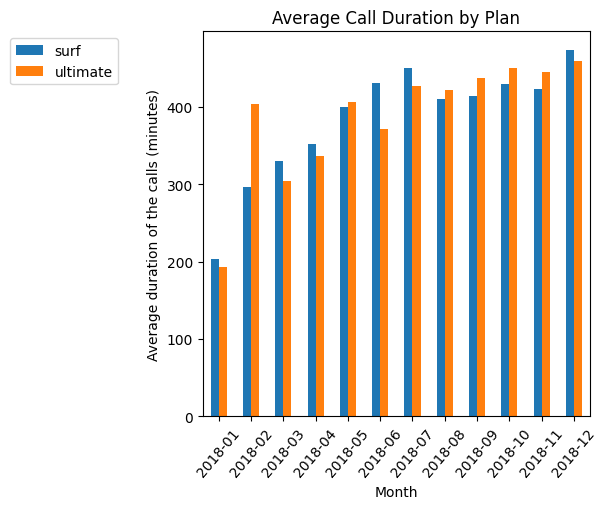

In [195]:
# We create a bar plot to visually compare the average number of minutes used per month for each plan. 

pivot_result_calls_mean.plot(kind='bar',
                  xlabel='Month',
                  ylabel='Average duration of the calls (minutes)',
                  rot=50,
                  alpha = 1,
                  title = 'Average Call Duration by Plan',
                  figsize=[5,5])
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right')
plt.show()





🔍 **Insights**: Average Call Duration by Plan

- Average call duration increased steadily over the year for both plans.   
- Ultimate had greater variability early in the year but aligned with Surf in later months.  
- Both plans converged toward similar usage patterns by the end of the year.


➡️ 📞 **3**. We compare the **number of minutes users of each plan require each month and plot a histogram**.

In [196]:

# Calculate the mean and the variance of the monthly call duration

calls_per_plan_total = data_by_user_month.groupby(['plan'])['duration_minutes']
calls_per_plan_total.describe()




,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,428.749523,234.453150,0.0,272.0,425.0,576.00,1510.0
ultimate,720.0,430.450000,240.508762,0.0,260.0,424.0,565.25,1369.0


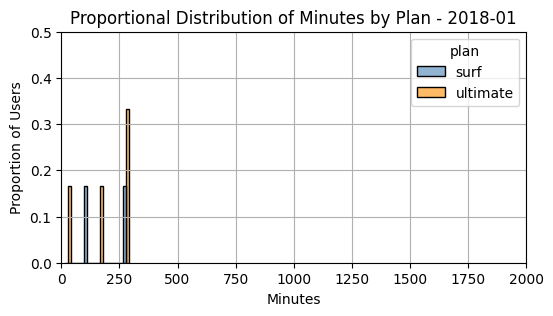

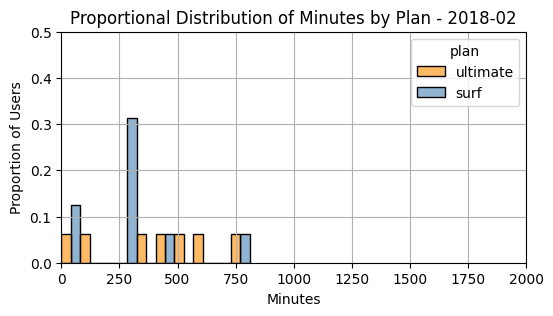

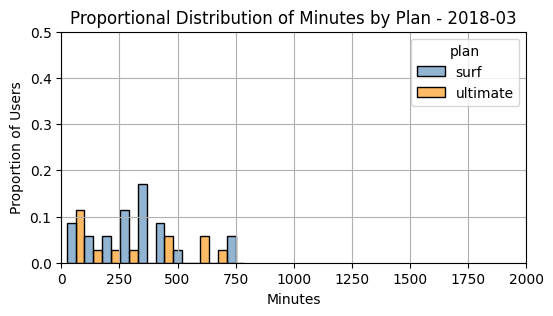

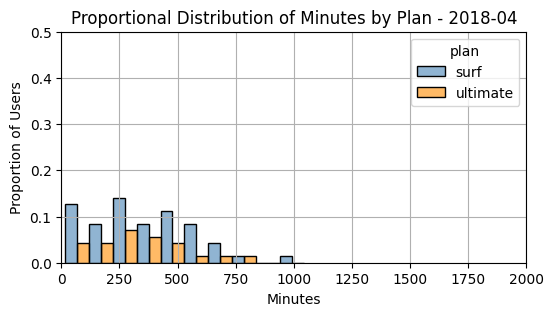

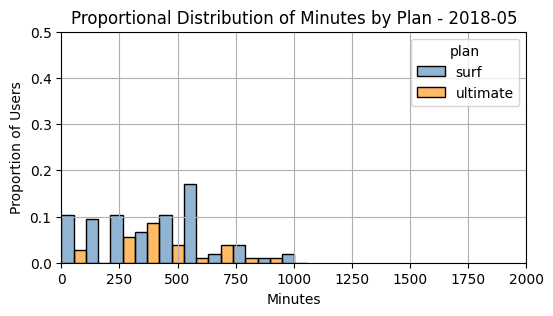

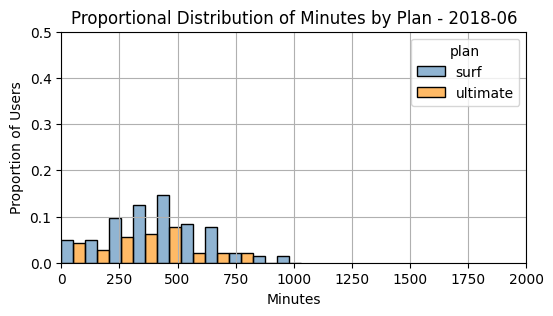

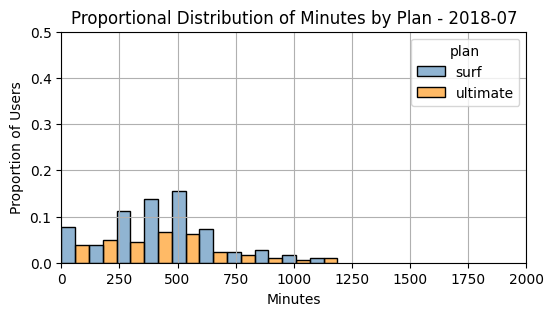

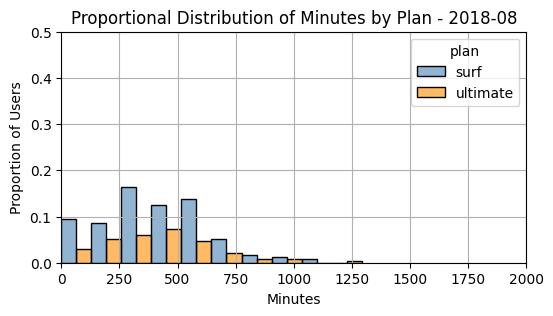

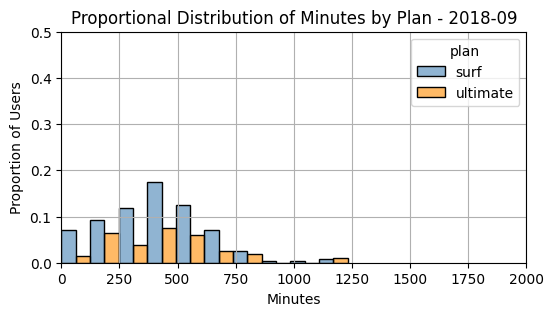

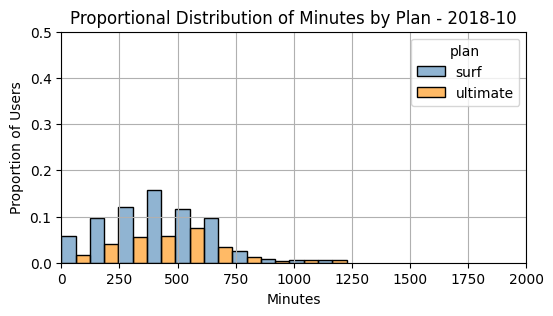

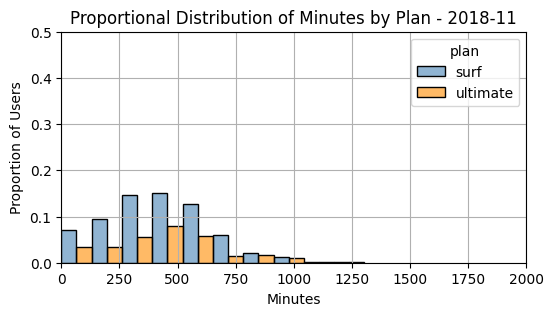

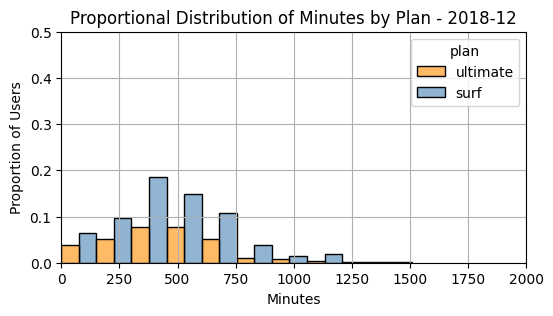

In [197]:


custom_palette = {"surf": "steelblue", "ultimate": "darkorange"}


months = sorted(data_by_user_month['month'].unique())

for month in months:
    subset = data_by_user_month[data_by_user_month['month'] == month]
    
    plt.figure(figsize=(6, 3))
    ax = sns.histplot(data=subset,
             x='duration_minutes',
             hue='plan',
             bins=10,
             multiple='dodge',
             stat='probability',
             alpha=0.6,
             palette = custom_palette)
  
    plt.title(f"Proportional Distribution of Minutes by Plan - {month}")
    plt.xlabel("Minutes")
    plt.ylabel("Proportion of Users")
    plt.grid(True)
    plt.xlim(0, 2000)
    plt.ylim(0, 0.5)   

   
    plt.show()

🔍 **Insights**: **number of minutes users of each plan require each month**

- Minute usage increased over the year, especially from April onward.  
- Surf users tend to use fewer minutes; Ultimate users show broader usage.  
- Distributions stabilized mid-year, suggesting more consistent behavior.  
- Plan differences blurred over time, with overlapping usage patterns.  
- Proportional histograms enabled fair comparison across months and plans.

<div style="border: 2px solid #1976D2; background-color: #E3F2FD; padding: 15px; border-radius: 5px;">
  📞 <strong>We plot two histograms, one per plan, that show the distribution of call durations in minutes.</strong>
</div>

Text(0, 0.5, 'Frequency')

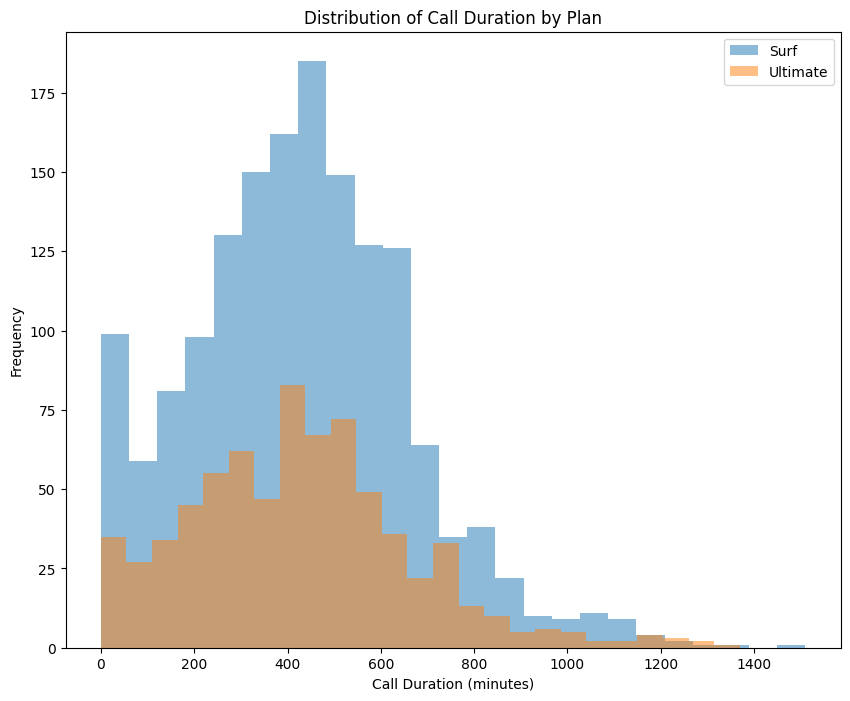

In [201]:

data_by_user_month.groupby('plan')['duration_minutes'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Surf', 'Ultimate'])
plt.title('Distribution of Call Duration by Plan')
plt.xlabel('Call Duration (minutes)')
plt.ylabel('Frequency')


<div style="border: 2px solid #1976D2; background-color: #E3F2FD; padding: 15px; border-radius: 5px;">
  📶 <strong>Among the users included in this dataset, call durations under the Surf plan tend to be shorter and more concentrated, whereas Ultimate plan users show a broader spread and slightly higher durations.</strong>
</div>

📌 **Note on methodology**

At first, I aggregated total minutes per plan and month, but realized this didn’t capture how usage varied between users.  
Then, I tried summing total minutes per user across all months, which avoided duplication but lost the month-by-month perspective.  
I also initially plotted one histogram per month without adjusting for user counts—this gave a rough idea, but didn’t reflect proportional distributions.  
Since I knew the number of users per plan per month, I decided to use proportional histograms instead.  

Throughout the process, I explored different settings (e.g., bin sizes, axis limits, color palettes) to improve readability and ensure fair visual comparisons.  

I believe that this final approach best preserves user-level detail and supports accurate monthly comparisons, making it the most aligned with the task.


➡️ 📞 **4**. We **plot a boxplot** to visualize the distribution of the monthly call duration

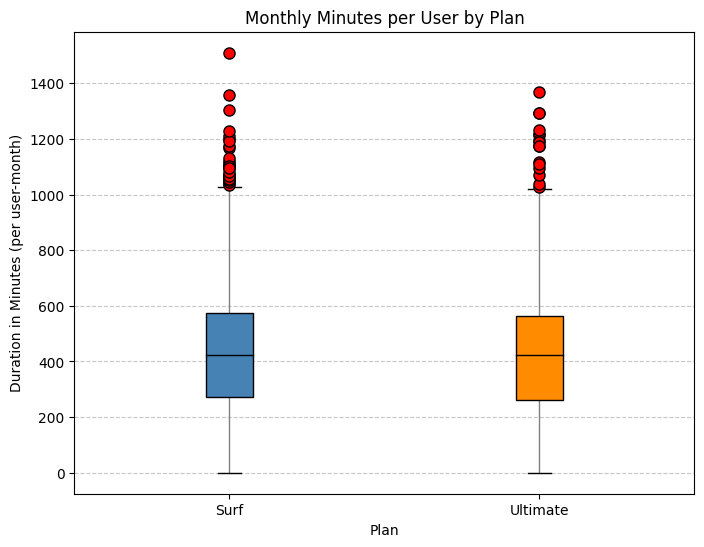

In [202]:

calls_plot = data_by_user_month[['plan', 'duration_minutes']]

colors = ['steelblue', 'darkorange']

plt.figure(figsize=(8, 6))

box = plt.boxplot(
    [calls_plot[calls_plot['plan'] == 'surf']['duration_minutes'],
     calls_plot[calls_plot['plan'] == 'ultimate']['duration_minutes']],
    labels=['Surf', 'Ultimate'],
    patch_artist=True,
    medianprops={'color': 'black'},
    whiskerprops={'color': 'gray'},
    flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8}
)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Monthly Minutes per User by Plan')
plt.xlabel('Plan')
plt.ylabel('Duration in Minutes (per user-month)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

🔍 **Insights**:: Boxplot – Monthly Minutes per User by Plan

This boxplot visualizes the monthly call duration for individual users, grouped by plan.  
- Both plans show similar medians (~400–450 minutes), but **Surf** has more outliers and a longer overall range.  
- A notable number of **high-usage outliers** are present in both plans, exceeding 1000 minutes.  
  It is particularly notable that **many Surf users exceed the plan’s limit (500 minutes)**, while **no Ultimate user surpasses the 3000-minute allowance**.

This distribution reflects real behavioral differences among users within each plan.

📌 **Note:**  
Compared to an aggregated view (total minutes per plan per month), this user-level analysis avoids distortion caused by **differences in group size**.


📞 🧾 **FINAL CONCLUSIONS**

- **General Trend**: Both Surf and Ultimate plans showed a steady increase in call duration over the year, with more users shifting to higher usage brackets month by month.

- **Distribution Patterns**: Histograms showed that Surf users were more concentrated in lower-duration brackets, while Ultimate users had a more evenly spread usage across mid-range bins. Despite this, both plans gradually converged toward similar patterns in later months.

- **Average Duration**: Mean call durations were similar across plans (~445 minutes), but Surf showed slightly higher values in the second half of the year.

- **Variability**: While overall standard deviation was slightly higher for Ultimate, boxplots revealed that **Surf had more extreme outliers** and a **wider overall range**, whereas **Ultimate showed greater variability in its central 50% (IQR)**.

- **Outliers and Spread**: Both plans included high-usage outliers (over 1000 minutes).**Many Surf users exceed the plan’s limit (500 minutes)**, while **no Ultimate user surpasses the 3000-minute allowance**.
 

### Messages

➡️ 💬  **1**. We **calculate descriptive statistics** for the aggregated and merged data and  compare descriptive statistics of monthly number of messages between the two available plans: surf and ultimate

In [203]:

mssg_per_plan_month = data_by_user_month.groupby(['plan'])['n_messages'].describe()
mssg_per_plan_month


,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,31.159568,33.566717,0.0,3.0,24.0,47.0,266.0
ultimate,720.0,37.551389,34.767179,0.0,7.0,30.0,61.0,166.0


In [204]:

mssgs_per_plan_total_var = data_by_user_month.groupby(['plan'])['n_messages'].var().reset_index()
mssgs_per_plan_total_var.rename(columns={'messages': 'mssgs_var'}, inplace=True)
mssgs_per_plan_total_var



,plan,n_messages
0,surf,1126.724522
1,ultimate,1208.756744


🔍 **Insights**:: Descriptive Statistics by Plan

- On average, **Ultimate** users send more messages per month than **Surf** users.  
- Although standard deviations are similar in absolute terms, **Surf** users show slightly more variability   
- Despite this, the **maximum number of messages is higher for Surf** users, indicating occasional peaks. **No Ultimate user exceeds the 1000-message limit**.  
- The **median (50th percentile)** is also higher for Ultimate, suggesting more consistent use.

➡️ 💬 **2**. We **compare average number of messages users of each plan tend to send each month**. 

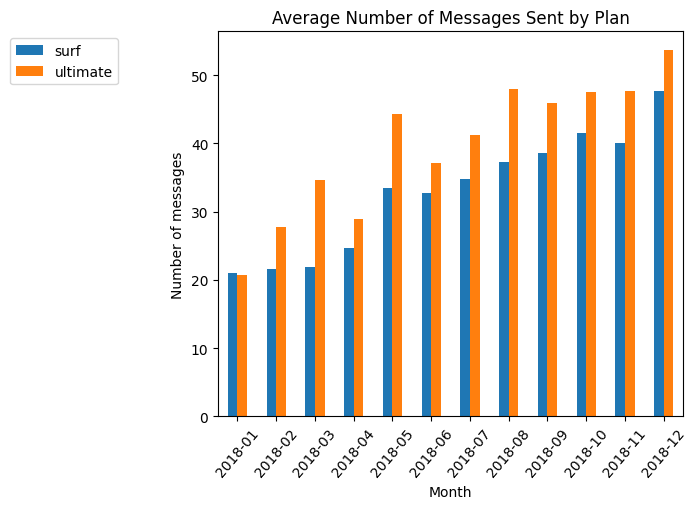

In [56]:

messages_per_plan_mean = data_by_user_month.groupby(['plan','month'])['n_messages'].mean()
messages_per_plan_mean = messages_per_plan_mean.reset_index()
messages_per_plan_mean


pivot_result_messg_mean = pd.pivot_table(
    messages_per_plan_mean,
    values='n_messages',      
    index='month',          
    columns='plan',     
    aggfunc=np.mean,                   
    fill_value=0 )


pivot_result_messg_mean
pivot_result_messg_mean.plot(kind='bar',
                  xlabel='Month',
                  ylabel='Number of messages',
                  rot=50,
                  alpha = 1,
                  title = 'Average Number of Messages Sent by Plan',
                  figsize=[6,5])
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right')
plt.show()


🔍 **Insights**:: Average Number of Messages Sent by Plan

- Average call duration increased steadily over the year for both plans. 
- **Ultimate** users tend to send more messages.  
- Both plans converged toward similar usage patterns.

➡️ 💬 **3**. We compare the **number of messages sent per plan each month and plot a histogram**.

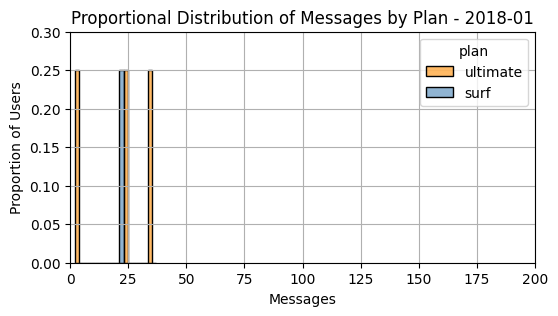

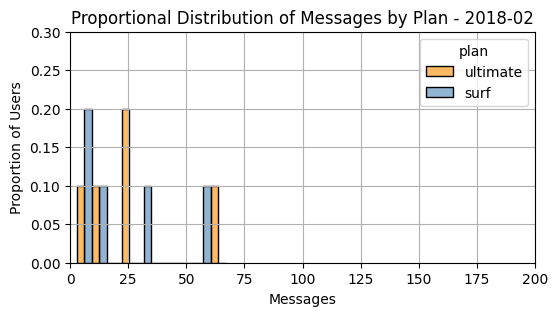

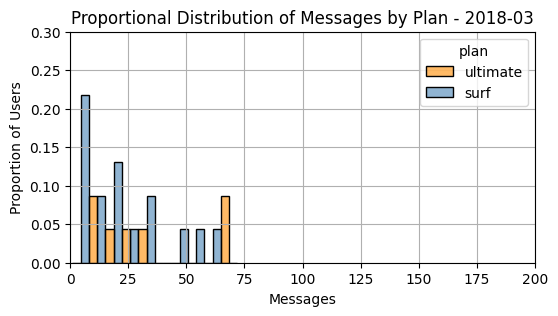

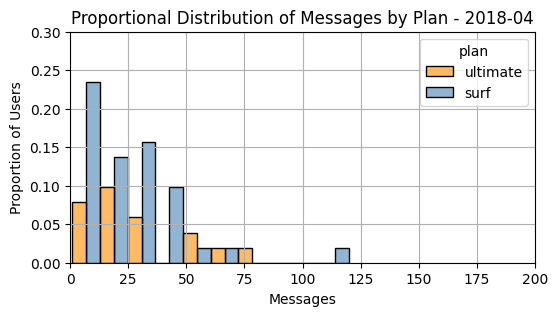

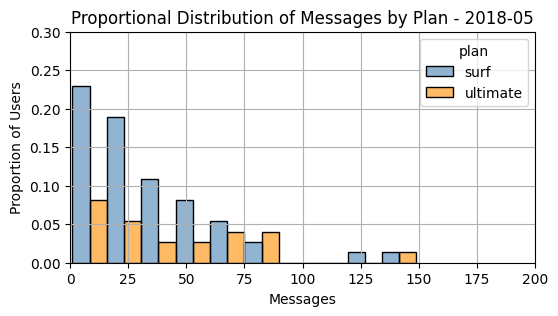

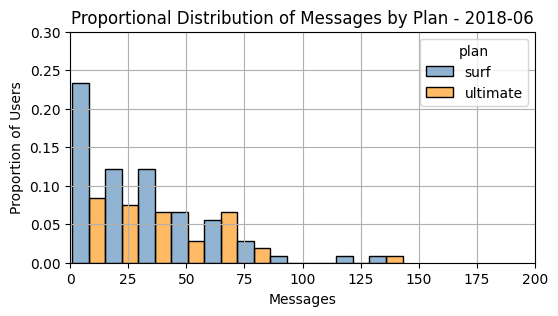

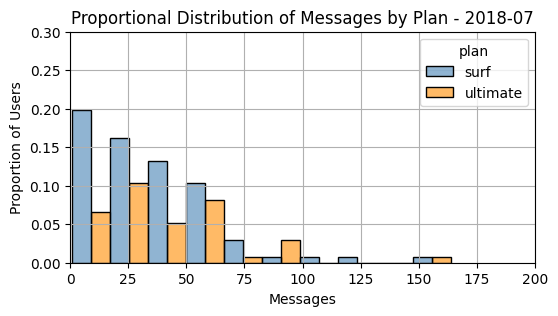

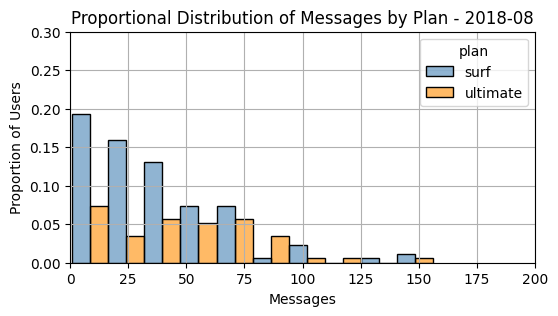

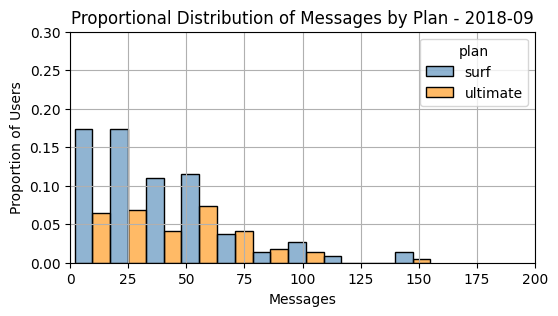

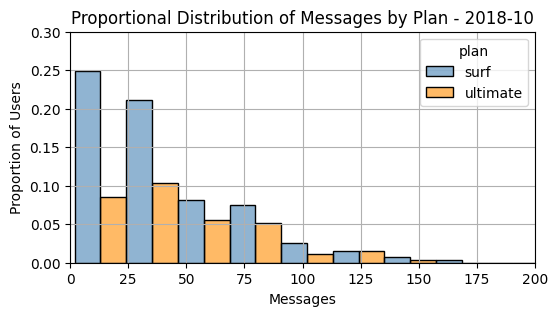

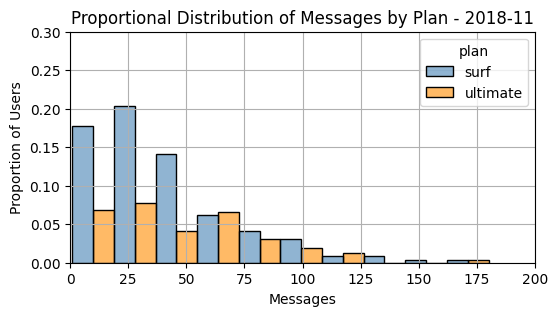

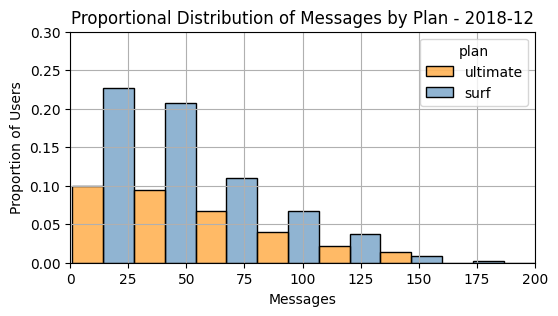

In [57]:

custom_palette = {"surf": "steelblue", "ultimate": "darkorange"}


months = sorted(data_by_user_month['month'].unique())

for month in months:
    subset = data_by_user_month[data_by_user_month['month'] == month]
    
    plt.figure(figsize=(6, 3))
    ax = sns.histplot(data=subset,
             x='n_messages',
             hue='plan',
             bins=10,
             multiple='dodge',
             stat='probability',
             alpha=0.6,
             palette = custom_palette)
  
    plt.title(f"Proportional Distribution of Messages by Plan - {month}")
    plt.xlabel("Messages")
    plt.ylabel("Proportion of Users")
    plt.grid(True)
    plt.xlim(0, 200)
    plt.ylim(0, 0.3)   

   
    plt.show()





🔍 **Insights**:: Proportional Distribution of Messages by Month**

- Most **Surf** users consistently fall within the **0–50 message range**, suggesting more frequent but lighter usage.  
- **Ultimate** users appear more often in the **50–100 range**, especially from mid-year onward, indicating a trend toward heavier engagement.  
- Over the course of the year, the **spread of message usage increases** in both plans, with broader distributions and more users occupying higher brackets.  
- Despite these changes, **Surf maintains a more concentrated distribution**, while **Ultimate** shows a more balanced spread across bins.



<div style="border: 2px solid #1976D2; background-color: #E3F2FD; padding: 15px; border-radius: 5px;">
  💬<strong>We plot two histograms, one per plan, that show the distribution of the number of messages sent.</strong>
</div>

Text(0, 0.5, 'Frequency')

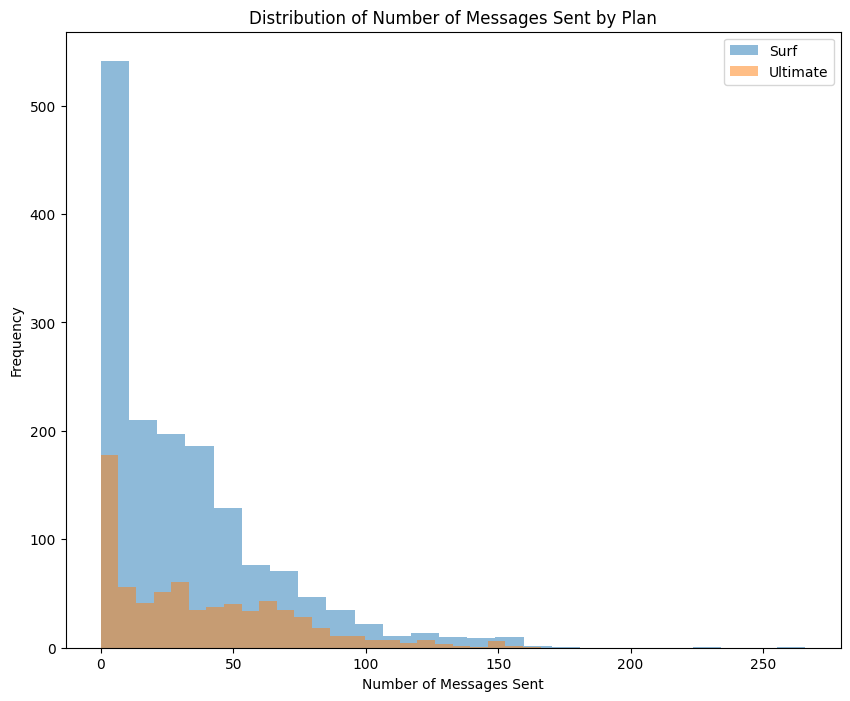

In [216]:
data_by_user_month.groupby('plan')['n_messages'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Surf', 'Ultimate'])
plt.title('Distribution of Number of Messages Sent by Plan')
plt.xlabel('Number of Messages Sent')
plt.ylabel('Frequency')


<div style="border: 2px solid #1976D2; background-color: #E3F2FD; padding: 15px; border-radius: 5px;">
  💬 <strong>The histogram shows the distribution of the number of messages sent by users in each plan. In this dataset, Surf users tend to send fewer messages overall, while Ultimate users show a wider spread, including higher message counts. These observations are descriptive and may reflect characteristics of the sampled users rather than the plans themselves.</strong>
</div>

➡️ 💬 **4**. We **plot a boxplot** to visualize the distribution of the monthly number of sent messages.

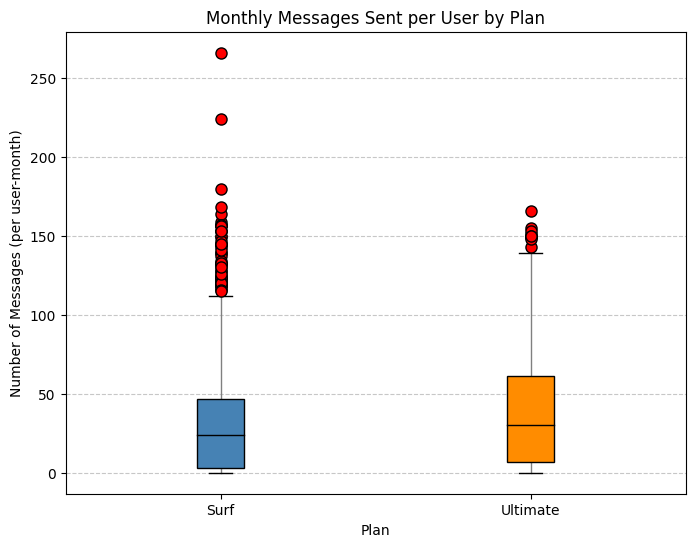

In [217]:

messgs_plot = data_by_user_month[['plan', 'n_messages']]

colors = ['steelblue', 'darkorange']

plt.figure(figsize=(8, 6))

box = plt.boxplot(
    [messgs_plot[messgs_plot['plan'] == 'surf']['n_messages'],
     messgs_plot[messgs_plot['plan'] == 'ultimate']['n_messages']],
    labels=['Surf', 'Ultimate'],
    patch_artist=True,
    medianprops={'color': 'black'},
    whiskerprops={'color': 'gray'},
    flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8}
)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Monthly Messages Sent per User by Plan')
plt.xlabel('Plan')
plt.ylabel('Number of Messages (per user-month)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




🔍 **Insights**:: Boxplot — Monthly Messages Sent per User by Plan

This boxplot visualizes the number of messages sent monthly by individual users, grouped by plan.

- **Surf** has a lower median (~30 messages) but shows more outliers and a longer overall range.  
- **Ultimate** has a higher median (~40 messages) and exhibits fewer outliers with a more compact distribution.  
- It is notable that **many Surf users exceed the plan's free message limit (50 messages)**, while **no Ultimate user exceeds the 1000-message limit**.  
- These patterns reflect real behavioral differences among users within each plan and may have direct billing implications.


💬 🧾 **FINAL CONCLUSIONS** — Monthly Messages Sent by Plan

- On average, Ultimate users send more messages per month than Surf users, with higher medians and a more balanced distribution across usage levels.

- Surf users tend to concentrate in the lower message brackets (0–50), with many exceeding the plan’s free message limit of 50. In contrast, **no Ultimate user exceeds the 1000-message threshold**.

- Over the course of the year, the spread of message usage increases in both plans, with a broader range of behaviors emerging — particularly in Ultimate.

- Although the standard deviation is similar across plans, Surf shows more extreme outliers and a longer overall range, while Ultimate displays greater consistency within its core usage group.

- These patterns suggest meaningful behavioral differences between plans and may have practical implications for pricing, engagement, and plan design.


### Internet

➡️ 🛜  **1**. We **calculate descriptive statistics** for the aggregated and merged data and  compare descriptive statistics of monthly amount of internet traffic consumed by users pbetween the two available plans: surf and ultimate.  

In [218]:

gb_per_plan_month = data_by_user_month.groupby(['plan'])['gb_used'].describe()
gb_per_plan_month


,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,16.670693,7.847522,0.0,12.0,17.0,21.0,70.0
ultimate,720.0,17.306944,7.670108,0.0,13.0,17.0,21.0,46.0


In [219]:

gb_per_plan_month_var = data_by_user_month.groupby(['plan'])['gb_used'].var().reset_index()
gb_per_plan_month_var.rename(columns={'gb_used': 'gb_used_var'}, inplace=True)
gb_per_plan_month_var


,plan,gb_used_var
0,surf,61.58360
1,ultimate,58.83055



🔍 **Insights**:: Descriptive Statistics by Plan

- On average, **Ultimate** users consume more GB per month than **Surf** users.  
- Although standard deviations are similar in absolute terms, **Surf** users show slightly more variability.  
- Despite this, the **maximum data usage is higher among Surf** users, indicating occasional peaks.  
- The **median (50th percentile)** is the same for both plans.  
- For Surf users, both the **median and the mean exceed the 15 GB limit**, indicating that most users go over their plan’s included data.  
- For Ultimate users, **more than 75% stay below the 30 GB limit**, suggesting that most users remain within their included data allowance.

➡️ 🛜 **2**. We **compare average number of minutes used per month in each plan**. 

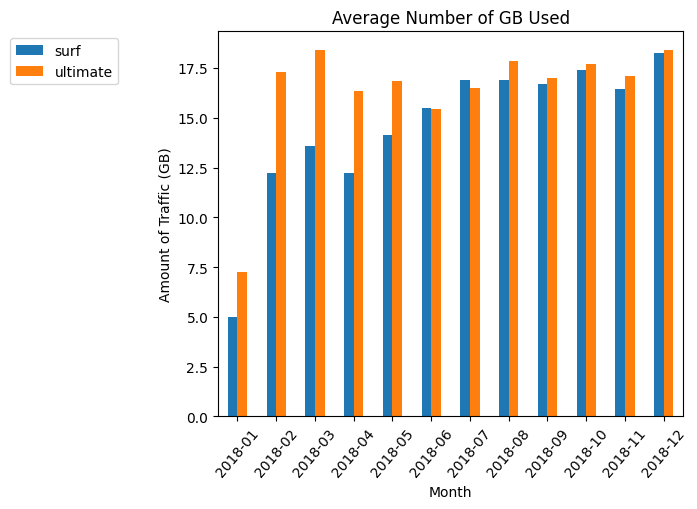

In [220]:
gb_per_plan_mean = data_by_user_month.groupby(['plan','month'])['gb_used'].mean().reset_index()

pivot_result_gb_mean = pd.pivot_table(
    gb_per_plan_mean,
    values='gb_used',      
    index='month',          
    columns='plan',     
    aggfunc=np.mean,                   
    fill_value=0 )


pivot_result_gb_mean
pivot_result_gb_mean.plot(kind='bar',
                  xlabel='Month',
                  ylabel='Amount of Traffic (GB)',
                  rot=50,
                  alpha = 1,
                  title = 'Average Number of GB Used',
                  figsize=[6,5])
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right')
plt.show()


🔍 **Insights**:: Average Number of GB Used by Plan

- Average data usage increased steadily over the year for both plans.  
- **Ultimate** users tend to consume more data on average.  
- There is a noticeable peak in data usage among **Ultimate** users in February and March.  
- **Surf** users started with lower usage but gradually increased over the year, eventually reaching levels comparable to Ultimate — suggesting a progressive adoption or growing data needs.  
- By the end of the year, both plans converged toward similar average usage levels.


➡️ 🛜 **3**. We compare the **amount of messages users of each plan require each month and plot a histogram**.

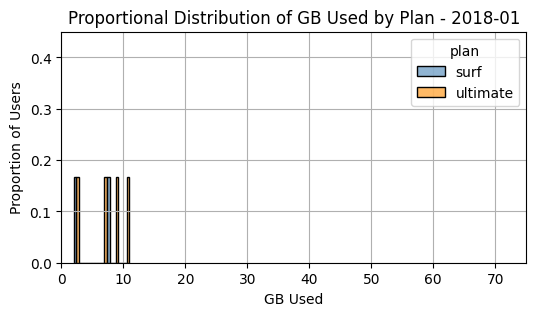

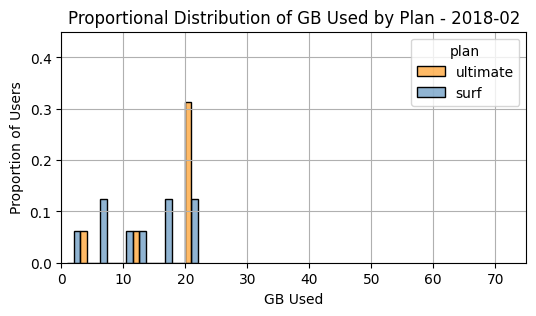

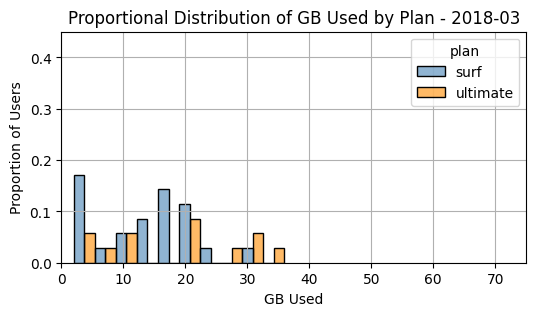

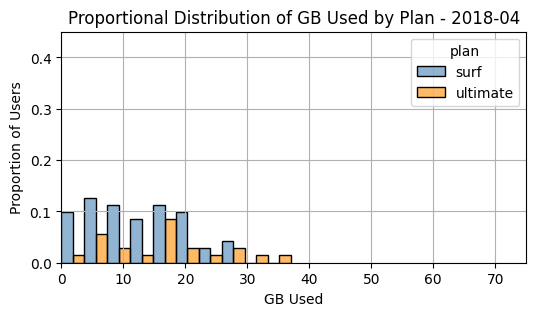

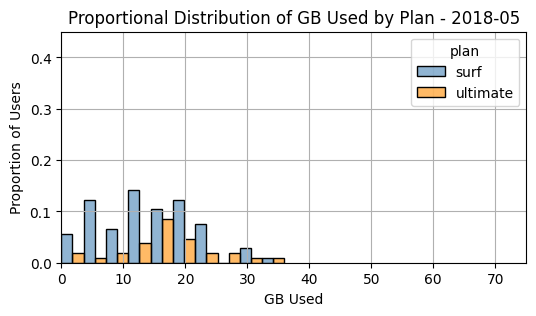

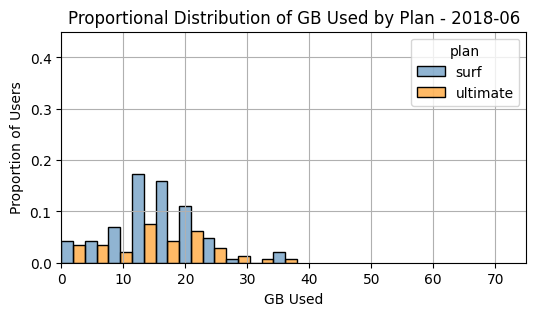

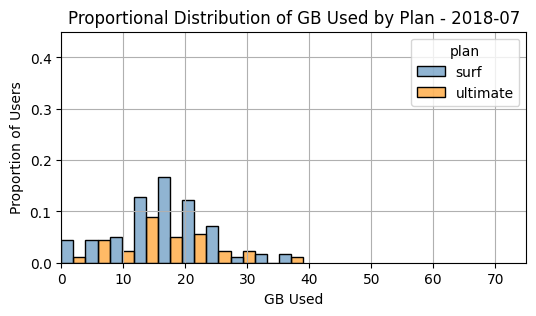

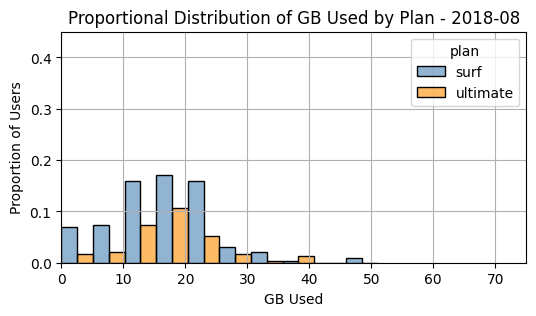

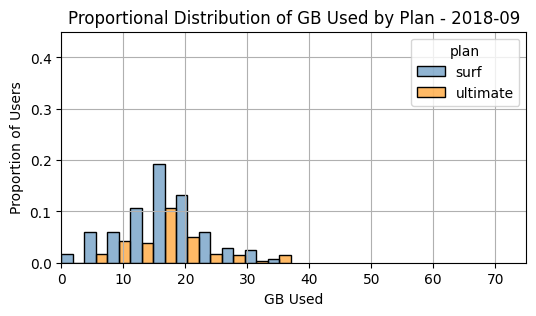

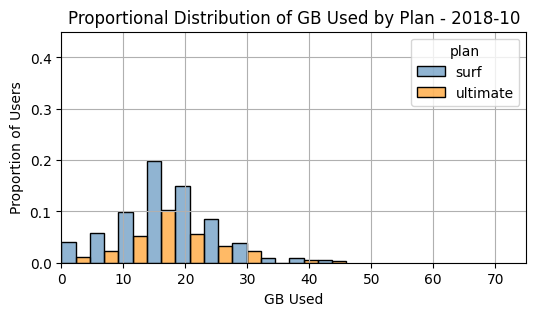

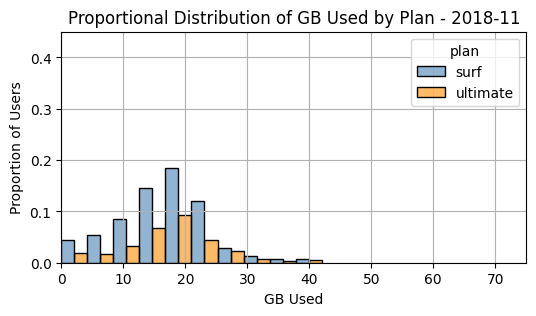

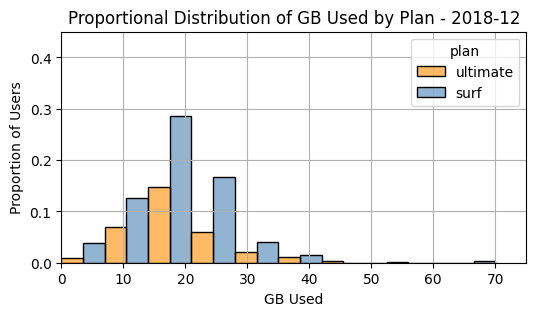

In [221]:

custom_palette = {"surf": "steelblue", "ultimate": "darkorange"}


months = sorted(data_by_user_month['month'].unique())

for month in months:
    subset = data_by_user_month[data_by_user_month['month'] == month]
    
    plt.figure(figsize=(6, 3))
    ax = sns.histplot(data=subset,
             x='gb_used',
             hue='plan',
             bins=10,
             multiple='dodge',
             stat='probability',
             alpha=0.6,
             palette = custom_palette)
  
    plt.title(f"Proportional Distribution of GB Used by Plan - {month}")
    plt.xlabel("GB Used")
    plt.ylabel("Proportion of Users")
    plt.grid(True)
    plt.xlim(0, 75)
    plt.ylim(0, 0.45)   

   
    plt.show()



🔎 ****Insights**: Proportional Distribution of Monthly Internet Usage per User**

- In the early months of the year, **Surf** users showed a more concentrated usage pattern, mostly within the **5–15 GB** range, while **Ultimate** users had more presence in higher bins, particularly around **15–25 GB**.  
- From April onwards, the distributions for both plans became wider, with users increasingly spread across **a broader range of data consumption**, especially between 10 and 30 GB.  
- By mid-year, **Surf and Ultimate users began to overlap more**, and by December their distributions were nearly indistinguishable — suggesting convergence in behavior regardless of plan.  
- Despite this convergence, **Surf consistently shows more users exceeding the plan’s 15 GB limit**, while **most Ultimate users stay below their 30 GB threshold**.  


<div style="border: 2px solid #1976D2; background-color: #E3F2FD; padding: 15px; border-radius: 5px;">
  🛜 <strong>We plot two histograms, one per plan, that show the distribution of internet use in GB.</strong>
</div>

Text(0, 0.5, 'Frequency')

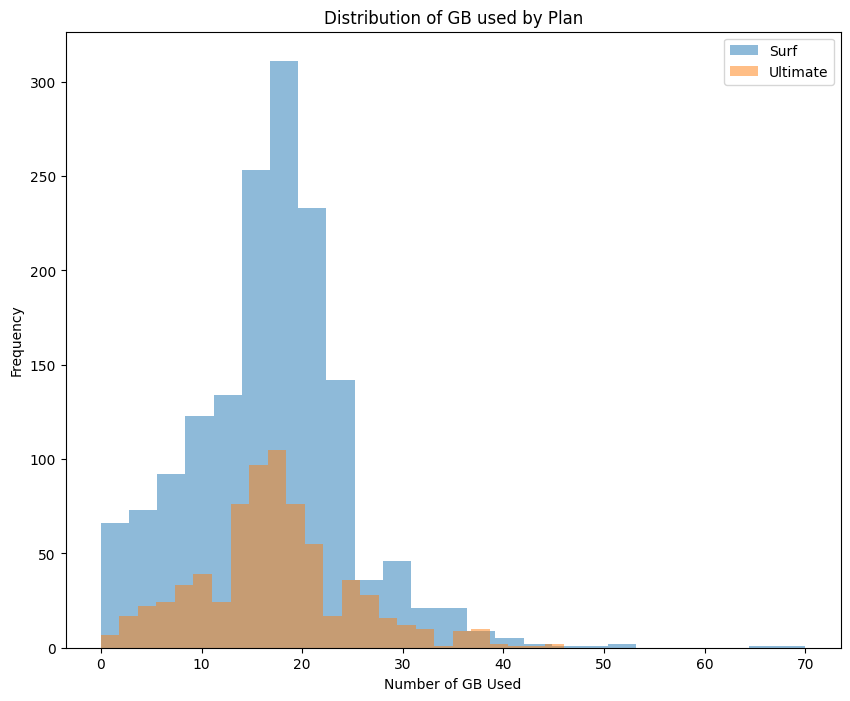

In [222]:
data_by_user_month.groupby('plan')['gb_used'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Surf', 'Ultimate'])
plt.title('Distribution of GB used by Plan')
plt.xlabel('Number of GB Used')
plt.ylabel('Frequency')


<div style="border: 2px solid #1976D2; background-color: #E3F2FD; padding: 15px; border-radius: 5px;">
  📶 <strong>This chart shows how data usage (in GB) is distributed among users of each plan. The key takeaway is not the total number of users, but which usage levels are more common. For example, Surf users tend to use around 15–25 GB, while Ultimate users are more spread out. These patterns help us understand typical usage behaviors per plan.</strong>
</div>

➡️ 🛜 **4**. We **plot a boxplot** to visualize the distribution of the monthly amount of internet traffic.

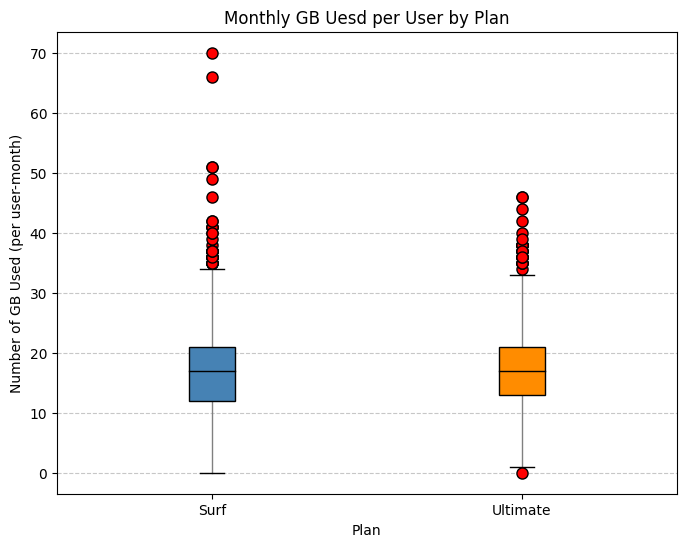

In [223]:
gb_plot = data_by_user_month[['plan', 'gb_used']]

colors = ['steelblue', 'darkorange']

plt.figure(figsize=(8, 6))

box = plt.boxplot(
    [gb_plot[gb_plot['plan'] == 'surf']['gb_used'],
     gb_plot[gb_plot['plan'] == 'ultimate']['gb_used']],
    labels=['Surf', 'Ultimate'],
    patch_artist=True,
    medianprops={'color': 'black'},
    whiskerprops={'color': 'gray'},
    flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8}
)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Monthly GB Uesd per User by Plan')
plt.xlabel('Plan')
plt.ylabel('Number of GB Used (per user-month)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



🔍 ****Insights****: Boxplot — Monthly GB Used per User by Plan

This boxplot visualizes the monthly data usage (in GB) of individual users, grouped by plan.

- Both plans have similar medians and overall range, but **Surf** shows more outliers. 
- **Ultimate** exhibits fewer outliers with a more compact distribution.  
- Notably **many Surf users exceed the plan's GB included limit (15 GB)**, while **less than the 25% of the Ultimate user exceeds the 30-GB limit**.
   
These patterns reflect real behavioral differences among users within each plan and may have direct billing implications.

🛜 🧾 **FINAL CONCLUSIONS — Monthly Internet Usage by Plan**

- On average, **Ultimate** users consume more GB per month than **Surf** users. However, over the year, **Surf** users progressively increased their usage, eventually reaching similar levels — suggesting adoption of heavier internet habits.
   
- While both plans have similar medians and overall ranges, **Surf** presents more outliers and a slightly wider spread, indicating more variability and occasional peaks.

- **Descriptive statistics** confirm that both the mean and median usage for Surf exceed the plan’s 15 GB limit, whereas **fewer than 25% of Ultimate users exceed the 30 GB limit**.


- The **boxplot** reinforces this difference: Surf shows more extreme values beyond the limit, while Ultimate users tend to cluster below their cap.

- **Histogram distributions** evolve throughout the year, with both plans showing an increasingly broader spread of user behavior. By December, the two distributions are nearly overlapping — reflecting a convergence in usage patterns.

- A temporary peak in Ultimate users' average usage in February and March may indicate seasonal variation or specific campaign effects.


## Revenue

➡️ 💰  **1**. We **calculate descriptive statistics** for the aggregated and merged data and  compare descriptive statistics of monthly amount of revenue between the two available plans: surf and ultimate.  

In [224]:
revenue_per_plan_month = data_by_user_month.groupby(['plan'])['monthly_revenue'].describe()
revenue_per_plan_month

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
surf,1573.0,60.706408,55.388042,20.0,20.0,40.36,80.36,590.37
ultimate,720.0,72.313889,11.395108,70.0,70.0,70.00,70.00,182.00


In [225]:
revenue_per_plan_month_var = data_by_user_month.groupby(['plan'])['monthly_revenue'].var().reset_index()
revenue_per_plan_month_var.rename(columns={'monthly_revenue': 'revenue_var'}, inplace=True)
revenue_per_plan_month_var

,plan,revenue_var
0,surf,3067.835152
1,ultimate,129.848486


🔍 **Insights**: Monthly Revenue per User by Plan

- **Ultimate** users generate a stable monthly revenue of 72 dollars, with very low variability. This aligns closely with the base plan fee of 70 dollars, suggesting that **most users stay within their plan’s limits**.  
- **Surf** users show a much wider range of monthly charges, with a mean of 60 and a standard deviation of over 53.  
- The median charge for Surf users is 41 dollars, just slightly above the base plan fee of 20 dollars — indicating that **many Surf users incur moderate to significant overage fees**.  
- Some Surf users are charged well over 100 dollars, with a maximum nearing **$590**, which strongly suggests **heavy usage beyond the included limits**.  
- These figures imply that while Ultimate provides **predictable revenue**, Surf presents **opportunities for higher income per user**, though with greater volatility.


➡️ 💰 **2**. We **compare average revenue per month in each plan**. 

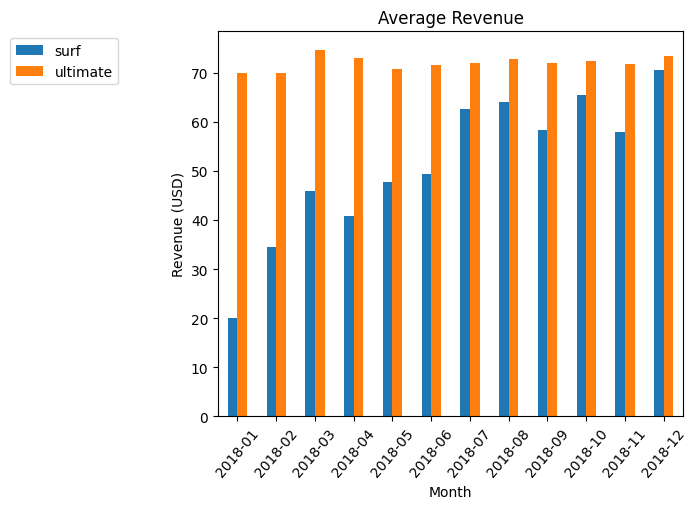

In [226]:
revenue_per_plan_mean = data_by_user_month.groupby(['plan','month'])['monthly_revenue'].mean().reset_index()

pivot_result_revenue_mean = pd.pivot_table(
    revenue_per_plan_mean,
    values='monthly_revenue',      
    index='month',          
    columns='plan',     
    aggfunc=np.mean,                   
    fill_value=0 )


pivot_result_revenue_mean
pivot_result_revenue_mean.plot(kind='bar',
                  xlabel='Month',
                  ylabel='Revenue (USD)',
                  rot=50,
                  alpha = 1,
                  title = 'Average Revenue',
                  figsize=[6,5])
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right')
plt.show()

🔍 **Insights**: Average Revenue by Plan

- Average revenue increased steadily for **Surf** and satys similar for **Ultimate**  over the year
- **Ultimate** users tend to consume more data on average.   
- **Surf** users started with lower usage but gradually increased over the year, eventually reaching levels comparable to Ultimate.  
- By the end of the year, both plans converged toward similar average usage levels.

➡️ 💰 **3**. We compare the **revenue each month and plot a histogram**.

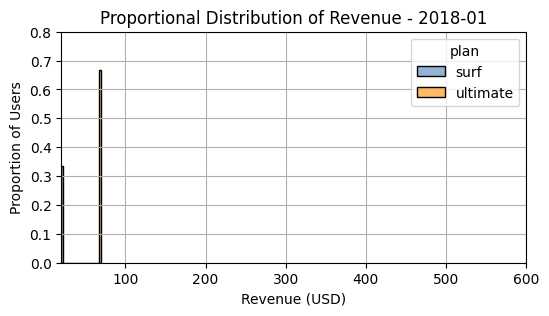

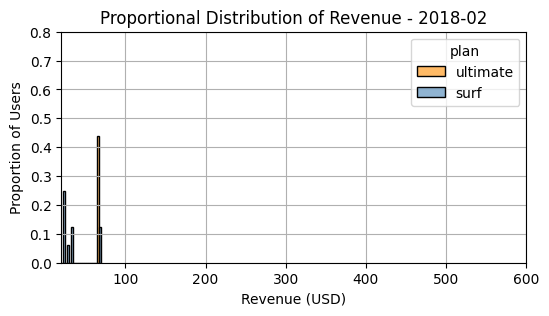

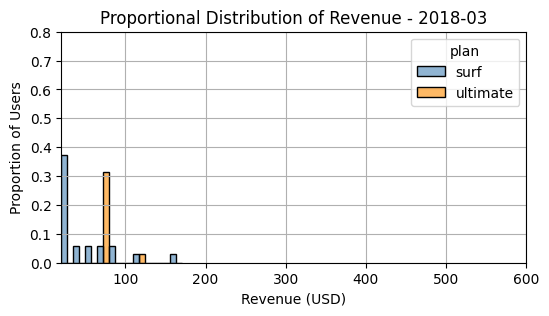

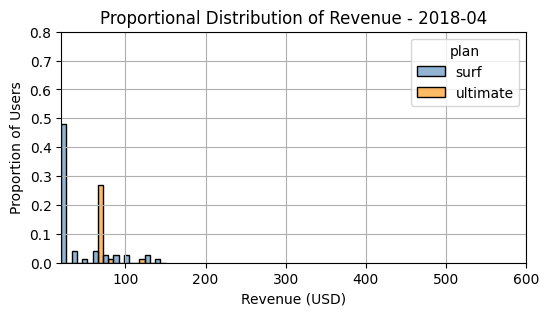

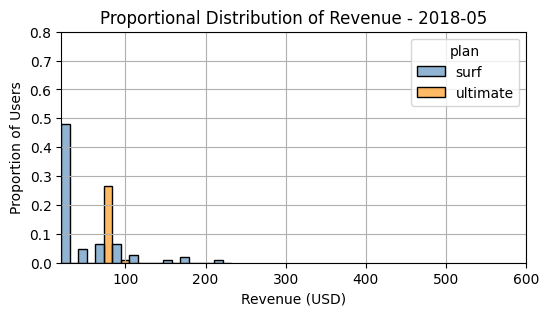

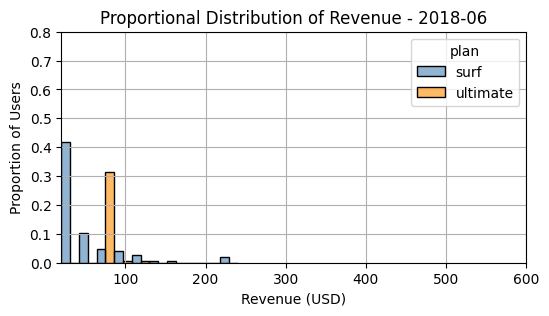

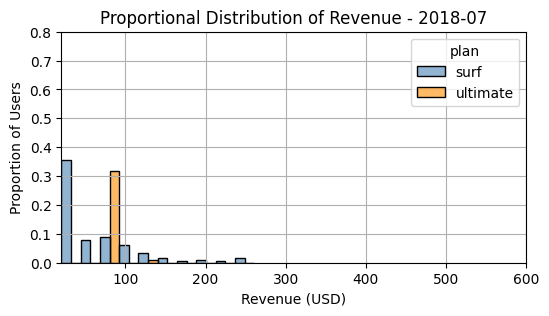

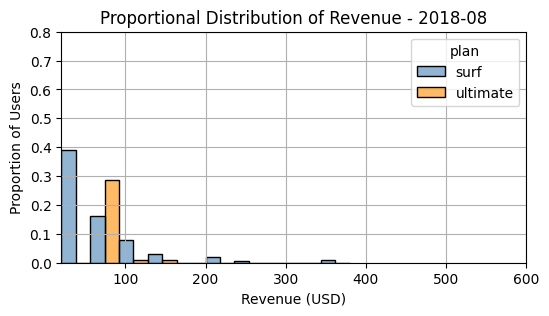

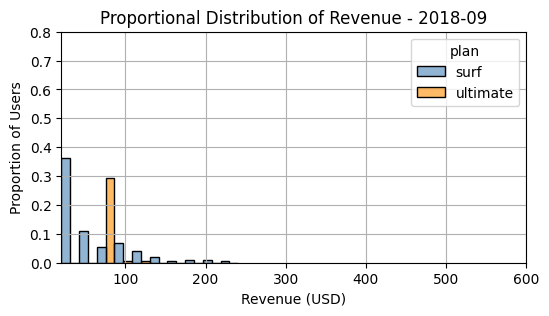

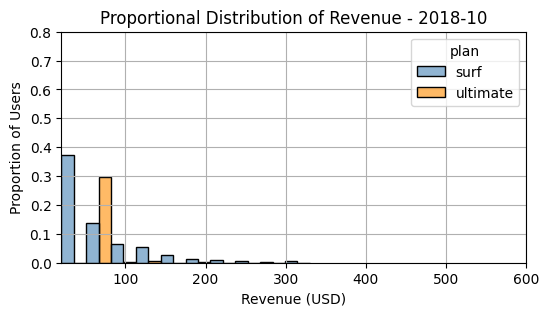

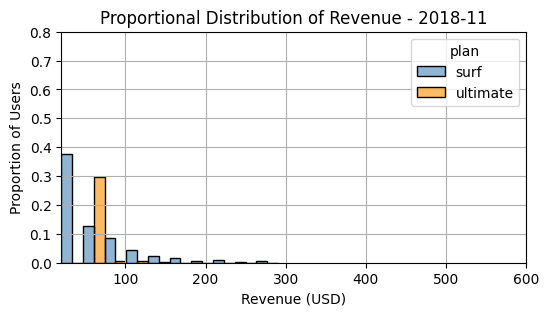

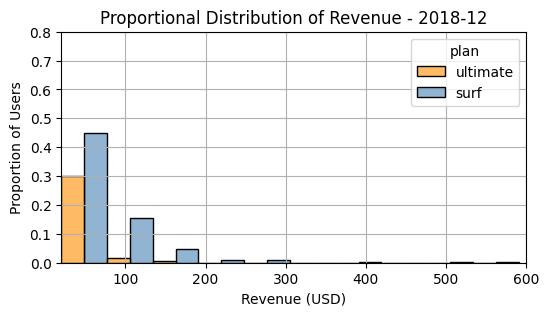

In [227]:
custom_palette = {"surf": "steelblue", "ultimate": "darkorange"}


months = sorted(data_by_user_month['month'].unique())

for month in months:
    subset = data_by_user_month[data_by_user_month['month'] == month]
    
    plt.figure(figsize=(6, 3))
    ax = sns.histplot(data=subset,
             x='monthly_revenue',
             hue='plan',
             bins=10,
             multiple='dodge',
             stat='probability',
             alpha=0.6,
             palette = custom_palette)
  
    plt.title(f"Proportional Distribution of Revenue - {month}")
    plt.xlabel("Revenue (USD)")
    plt.ylabel("Proportion of Users")
    plt.grid(True)
    plt.xlim(20, 600)
    plt.ylim(0, 0.8)   

   
    plt.show()


🔍 **Insights**: Proportional Distribution of Monthly Revenue per Plan

- Throughout the year, **Ultimate** users consistently cluster around the 70–75 range, reflecting the flat-rate nature of the plan.  
- In contrast, **Surf** users display a much broader revenue distribution, with a significant proportion paying above the 20 base price — often falling into 40–100 brackets and, in some cases, exceeding 200 and 500 USD.
- This indicates that **many Surf users incur overage charges**, leading to highly variable monthly revenue per user.  
- While the majority of Ultimate users generate predictable and stable income, **Surf contributes a higher ceiling for revenue**, driven by usage-based pricing.  
- The shape of the distributions remains stable over time, but Surf consistently shows **longer tails**, suggesting that a small but persistent subset of users produces high monthly bills.

<div style="border: 2px solid #1976D2; background-color: #E3F2FD; padding: 15px; border-radius: 5px;">
  💰 <strong>We plot two histograms, one per plan, that show the distribution of revenue in USD.</strong>
</div>


Text(0, 0.5, 'Frequency')

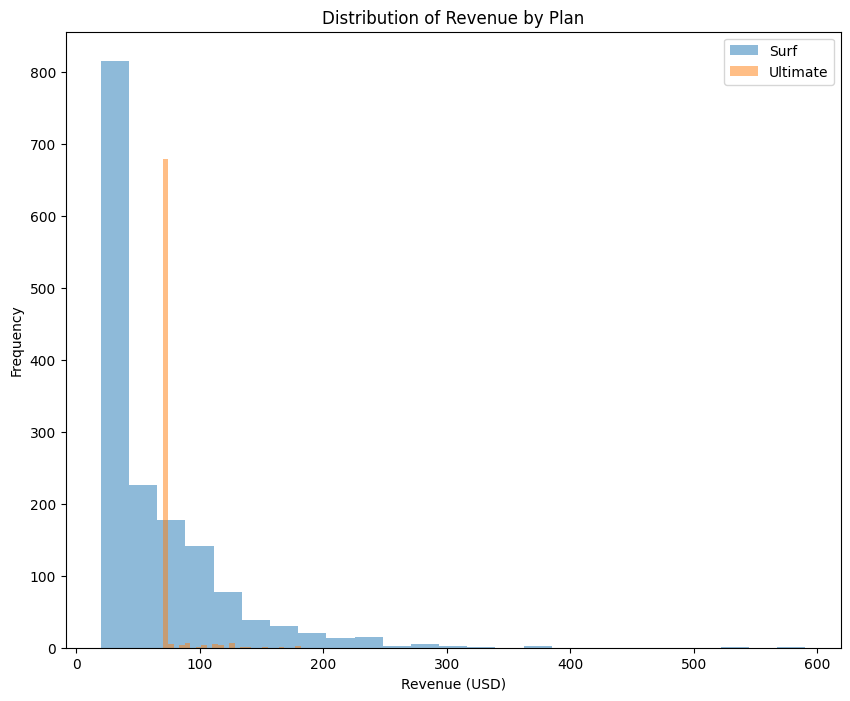

In [215]:
data_by_user_month.groupby('plan')['monthly_revenue'].plot.hist(alpha=0.5, legend=True, bins=25, figsize=(10,8))

plt.legend(['Surf', 'Ultimate'])
plt.title('Distribution of Revenue by Plan')
plt.xlabel('Revenue (USD)')
plt.ylabel('Frequency')

<div style="border: 2px solid #1976D2; background-color: #E3F2FD; padding: 15px; border-radius: 5px;">
  💵 <strong>This histogram shows how revenue per user is distributed for each plan. While Surf users generate a wide range of revenue values, Ultimate users mostly cluster around a fixed amount, likely reflecting the fixed plan cost. The important takeaway is not how many users fall into each range, but how differently the two plans behave in terms of revenue structure.</strong>
</div>


➡️ 💰 **4**. We **plot a boxplot** to visualize the distribution of the monthly revenue. 

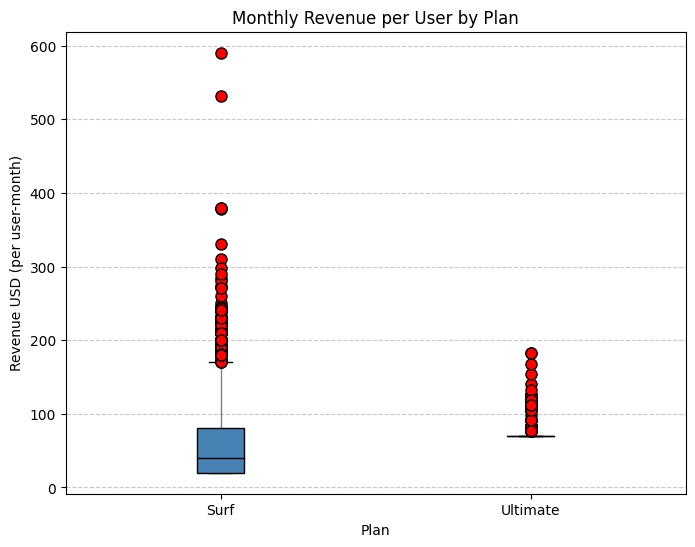

In [228]:
revenue_plot = data_by_user_month[['plan', 'monthly_revenue']]

colors = ['steelblue', 'darkorange']

plt.figure(figsize=(8, 6))

box = plt.boxplot(
    [revenue_plot[gb_plot['plan'] == 'surf']['monthly_revenue'],
     revenue_plot[gb_plot['plan'] == 'ultimate']['monthly_revenue']],
    labels=['Surf', 'Ultimate'],
    patch_artist=True,
    medianprops={'color': 'black'},
    whiskerprops={'color': 'gray'},
    flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8}
)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Monthly Revenue per User by Plan')
plt.xlabel('Plan')
plt.ylabel('Revenue USD (per user-month)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


🔍 **Insights**: Boxplot — Monthly Revenue per User by Plan

- **Ultimate** users show a compact and consistent revenue pattern, tightly grouped around the fixed monthly fee of $70 — with very few deviations or outliers.  
- **Surf** users, on the other hand, display a much wider spread and a large number of outliers.  
- The median revenue for Surf is notably lower than Ultimate’s, but the presence of many high outliers — some exceeding 200 and even 500 — reveals **significant revenue potential from heavy users**.  
- This confirms that Surf, while less predictable, allows for **greater upside in per-user revenue** due to its pay-per-use model.


💰 🧾 **FINAL CONCLUSIONS — Revenue Insights by Plan**

- **Ultimate** users generate highly predictable revenue, with most monthly charges tightly clustered around the $70 base plan fee. The distribution is narrow and consistent, with minimal variation or outliers.  
- **Surf** users, by contrast, exhibit a much wider range of monthly charges. While the base plan is only 20, many users exceed this amount — some significantly. The average monthly revenue per Surf user is ~60, with a long tail of outliers reaching beyond 500.  
- The **boxplot** confirms this: Surf users show a broader spread and a large number of high-value outliers, while Ultimate users are tightly grouped with fewer exceptions.  
- **Histograms** across all months reveal that Surf users are more likely to fall into higher revenue brackets compared to their base fee, whereas Ultimate users remain concentrated in a narrow, fixed range.  
- These findings reflect two contrasting revenue models:
  - **Ultimate** offers stable, predictable income with low variability.
  - **Surf** introduces greater variability and risk, but also **higher revenue potential per user** — especially from heavy users who incur overage fees

📊 **Hypothesis Test — Comparing Average Revenue Between Plans**

We test the hypothesis that the **average revenue from users of the Ultimate and Surf plans differs**.

- **Null Hypothesis (H₀):**  
  The average revenue from users of the **Ultimate** plan is equal to that of the **Surf** plan.  
  _μ₁ = μ₂_

- **Alternative Hypothesis (H₁):**  
  The average revenue from users of the **Ultimate** plan **differs** from that of the **Surf** plan.  
  _μ₁ ≠ μ₂_

This is a **two-tailed test** for a difference in means between independent samples.

## Test statistical hypotheses

<div style="border: 2px solid #1976D2; background-color: #E3F2FD; padding: 12px; border-radius: 5px;">
  ✅ <strong>Two-tailed Test ⬇️⬇️</strong>
</div>

In [234]:
# Create subsets for each plan

revenue_surf=data_by_user_month[data_by_user_month['plan'] == 'surf']['monthly_revenue']
revenue_ultimate=data_by_user_month[data_by_user_month['plan'] == 'ultimate']['monthly_revenue']

#Test the hypothesis:

alpha = 0.05  

results = st.ttest_ind(revenue_surf,revenue_ultimate,equal_var=False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis: the average revenue in Surf is significantly different from the average revenue in Ultimate.")
else:
    print("We can't reject the null hypothesis: there's no significant difference in average revenue between plans.")


p-value:  3.1703905481135734e-15
We reject the null hypothesis: the average revenue in Surf is significantly different from the average revenue in Ultimate.


📊 **Hypothesis Test — Comparing Average Revenue: NY-NJ Area vs. Other Regions**

We test the hypothesis that the **average revenue from users in the New York–Newark–Jersey City area differs** from that of users in other regions.

- **Null Hypothesis (H₀):**  
  The average revenue from users in **NY–NJ** is equal to that of users from **other cities**.  
  _μ₁ = μ₂_

- **Alternative Hypothesis (H₁):**  
  The average revenue from users in **NY–NJ** is **different** from that of users from other cities.  
  _μ₁ ≠ μ₂_

This is a **two-tailed test** for a difference in means between independent groups.


In [238]:


# Enrich the `data_by_user_month` DataFrame with the user's city information
data= data_by_user_month.merge(users[['user_id', 'city']],on='user_id',how='left')

# Create subsets for NY-NJ area and other regions
ny_users = data[data['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']
other_users = data[data['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']

#Test the hypothesis:

alpha = 0.05

results = st.ttest_ind(
    ny_users['monthly_revenue'],
    other_users['monthly_revenue'],
    equal_var=False
)
print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis: the average revenue in NY-NJ is significantly different from that in other regions.")
else:
    print("We can't reject the null hypothesis: there's no significant difference in average revenue between NY-NJ and other regions.")




p-value: 0.0335256158853001
We reject the null hypothesis: the average revenue in NY-NJ is significantly different from that in other regions.


## 🕵🏻‍♀️ General conclusion

This analysis aimed to determine which Megaline plan—Surf or Ultimate—generates more revenue per user, based on 2018 data from 500 clients.

We cleaned and aggregated the data monthly per user, calculated revenues, and applied consistent rounding methods. To avoid bias from unequal sample sizes (Surf users represent 68% of the total sample), we used user-level and proportional analysis.

📊 Findings:

Average revenue per user is higher for Ultimate (70 USD) than for Surf (60 USD).

However, Surf shows greater variability: while many users pay the base fee (20 USD), a significant portion exceed their limits, generating much higher revenues—some above 500 USD.

In contrast, Ultimate users mostly stay near the fixed monthly fee, with minimal variation or overage charges.

📌 Statistical tests confirmed that these differences are significant.

➡️ Conclusion:

Ultimate provides more stable and predictable revenue per user.

Surf has higher revenue potential from individual users due to overage fees, but also more fluctuation.

<div style="border-left: 4px solid #007acc; padding: 0.5em 1em; background-color: #f0f8ff;">

<p><strong>Based on this sample, the Ultimate plan is more profitable in terms of revenue.</strong><br>
It yields a higher average monthly revenue per user (<strong>70 USD</strong>) compared to the Surf plan (<strong>60 USD</strong>).</p>

<p>This is because most Ultimate users consistently pay the full monthly fee, resulting in <strong>stable and predictable income</strong>.<br>
In contrast, although some Surf users exceed their plan limits and generate high revenue, <strong>many others pay only the 20 USD base fee</strong>, leading to <strong>greater variability and lower average returns</strong>.</p>

<p>📌 <strong>Note:</strong><br>
To fully evaluate long-term profitability, we’d also need to consider <strong>churn rates</strong> and the <strong>actual number of users per plan</strong> in the complete customer base.</p>

</div>